# Experiments
This is where all data cleaning, feature selection, feature engineering, model building, and model evaluation will happen.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pycaret.classification import ClassificationExperiment

from typing import List

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

## Functions
Here I will define all the functions that are to be used in this project. There will be 2 categories of functions:
1) Flagging functions: Functions that return a list of ids of people who have potentially violated some logic as also discovered in analysis.ipynb.
2) Data cleaning functions: Ffunctions that help handle inconsistencies as discovered in analysis.ipynb.
3) Data processing functions: Functions that process the data.

### 1) Flagging Functions

In [2]:
def flag_no_emp_high_income(df: pd.DataFrame) -> List[int]:
    return list(df[(df['person_emp_length']==0) & (df['person_income']>0)]['id'])

def flag_min_emp_age_violation(df: pd.DataFrame) -> List[int]:
    return df[df['person_age'] - df['person_emp_length'] < 14]['id']

def flag_inconsistent_loan_percentage(df: pd.DataFrame) -> List[int]:
    actual_loan_percent_income = round(df['loan_amnt'] / df['person_income'], 2)
    inconsistent_percentages_df = df.iloc[df['loan_percent_income'].compare(actual_loan_percent_income).index]

    return inconsistent_percentages_df['id']

def flag_credit_history_violation(df: pd.DataFrame, min_age_for_credit: int) -> List[int]:
    df['years_from_min_age'] = df['person_age'] - min_age_for_credit
    credit_history_violaters_df = df[df['years_from_min_age'] < df['cb_person_cred_hist_length']]

    df.drop("years_from_min_age", axis=1, inplace=True)

    return credit_history_violaters_df

### 2) Data Cleaning Functions

In [3]:
def clean_age(df: pd.DataFrame, age_threshold: int = 100) -> pd.DataFrame:
    df.loc[df['person_age'] > age_threshold, 'person_age'] -= age_threshold
    return df

def clean_emp_length_by_age(df: pd.DataFrame, age_threshold: int = 100) -> pd.DataFrame:
    violaters = df[df['person_emp_length']>=100].index
    df.drop(violaters, axis=0, inplace=True)
    return df

def clean_underage_or_impossible_labor(df: pd.DataFrame, min_age_of_employment: int) -> pd.DataFrame:
    # Find the age of when the applicant first started working
    df['age_of_first_emp'] = df['person_age'] - df['person_emp_length']

    # Find applicants that started working before the min age and take the difference
    diff = 14 - df[df['age_of_first_emp'] < min_age_of_employment]['age_of_first_emp']

    # Subtract diff from person_emp_length
    df.loc[diff.index, 'person_emp_length'] = df.loc[diff.index, 'person_emp_length'] - diff

    # Verify results
    df['age_of_first_emp'] = df['person_age'] - df['person_emp_length']
    if len(df[df['age_of_first_emp']<min_age_of_employment]) != 0:
        raise ValueError(f"There exist an applicant that started working before they turned {min_age_of_employment}")

    # Drop age_of_first_emp
    df.drop("age_of_first_emp", axis=1, inplace=True)

    return df

def clean_loan_pct_income(df: pd.DataFrame) -> pd.DataFrame:
    df['loan_percent_income'] = round(df['loan_amnt'] / df['person_income'], 2)
    return df

def clean_credit_history(df: pd.DataFrame, min_age_for_credit: int) -> pd.DataFrame:
    # Find age of when the applicant started their credit history
    df['years_from_min_credit_age'] = df['person_age'] - min_age_for_credit

    # Find applicant that started their credit history prior to the min age and take the difference
    diff = df[df['years_from_min_credit_age'] < df['cb_person_cred_hist_length']]

    # Assign years_from_min_credit_age to cb_person_cred_hist_length
    df.loc[diff.index, 'cb_person_cred_hist_length'] = df.loc[diff.index, 'years_from_min_credit_age']

    # Verify results
    if len(df[(df['person_age'] - df['cb_person_cred_hist_length']) < min_age_for_credit]) != 0:
        raise ValueError(f"There exist an applicant that started their credit history before they turned {min_age_for_credit}")

    # Drop years_from_min_credit_age
    df.drop("years_from_min_credit_age", axis=1, inplace=True)

    return df

### 3) Data Processing Functions

In [4]:
def boolean_to_numeric(df: pd.DataFrame) -> pd.DataFrame:
    df['cb_person_default_on_file'] = df['cb_person_default_on_file'].map({'Y': 1, 'N': 0})
    return df

def ordinal_encoding(df: pd.DataFrame) -> pd.DataFrame:
    df['loan_grade'] = df['loan_grade'].map({
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7
    })

    return df

## Clean data
Before we begin experimenting, lets first clean both the training set and testing set so we have some consistency. The reason we're cleaning it through this method is because these data cleaning techniques real world interpretation of the data (despite the data being synthetically generated). After cleaning, we will begin experimenting.

In [5]:
# Clean train data
df_train = clean_age(df_train, 100)
df_train = clean_emp_length_by_age(df_train, 100)
df_train = clean_underage_or_impossible_labor(df_train, 14)
df_train = clean_loan_pct_income(df_train)
df_train = clean_credit_history(df_train, 18)
df_train = boolean_to_numeric(df_train)
# df_train = ordinal_encoding(df_train)

# Clean test data
df_test = clean_age(df_test, 100)
df_test = clean_emp_length_by_age(df_test, 100)
df_test = clean_underage_or_impossible_labor(df_test, 14)
df_test = clean_loan_pct_income(df_test)
df_test = clean_credit_history(df_test, 18)
df_test = boolean_to_numeric(df_test)
# df_test = ordinal_encoding(df_test)

# Store train ids
train_ids = df_train['id']
df_train.drop('id', axis=1, inplace=True)

# Store test_ids
test_ids = df_test['id']
df_test.drop('id', axis=1, inplace=True)

## Experiment Procedure
Now that the data has been cleaned, lets walk through the different settings that will be tested.

* Categorical Features Encoding
    * One-Hot Encoding
    * Label Encoding
* Combine Rare Features
    * No combination
    * Combine Rare Features - especially for loan_grade and person_home_ownership
* Feature Transform
    * Log-Transform
    * Box-Cox
    * Yeo-Johnson
* Normalization
    * No changes
    * Z-score
    * MinMax
    * Robust
* Target Imbalance
    * No changes
    * SMOTE
    * ADASYN
    * Undersampling
* Models
    * Non Tree-based
        * Logistic Regression (Baseline)
        * SVM Classifier
        * Naive Bayes
        * KNN Classifier
        * Ridge Classifier
    * Tree-based
        * Decision Tree (Baseline)
        * Random Forest
        * Extra Trees
        * AdaBoost
        * Gradient Boost
        * XGBoost
        * LightGBM

It's suboptimal to test every possible configuration listed above since there are way too many combinations. Therefore, experiment configurations will be done strategically and we will choose which experiments and configurations to run by following a sequential process. The process is defined as such:

#### Experiment 1: Categorical Encodings
There were 4 categorical features in the dataset (person_home_ownership, loan_intent, loan_grade, cb_person_default_on_file) but after cleaning the data as seen above, we have converted cb_person_default_on_file into a binary value. Next, we know that we want to apply ordinal encoding on loan_grade since it is inherently ordinal in nature. However, what we want to test in this first experiment is whether or not to combine rare categorical values in the 3 features - with a heavy focus on loan_grade and person_home_ownership. The experiments will be run as such:
- Test 1.0: No combination of rare categories in any features and apply ordinal encoding on all categories in loan_grade.
- Test 1.1: Combination of rare features where [A,B,C -> 'high', D,E,F,G -> low] for loan_grade and [OWN, MORTGAGE -> 1, RENT, OTHER -> 0] where person_home_ownership turns into has_house.

Observe which configuration yields better performance and remain with that configuration when conducting the rest of the experiments.

#### Experiment 2: Non Tree-based Model Optimization
Linear models are highly sensitive to outliers and the scale of the data. It would be tempting to simply remove the outliers in the dataset. However, as discussed in `analysis.ipynb`, this is ill-advised as our data is inherently skewed in nature and those outliers are necessary for interpretation of loan applicants who fall outside the "normal" range. Instead, in this experiment, only conduct transformations and normalizations to better fit the models. The experiments will be run as such:
- Test 2.0.0: No transformation or normalization will be applied.
- Test 2.1.0: Apply log-transformation and no normalization.
- Test 2.1.1: Apply log-transformation and apply z-score normalization.
- Test 2.1.2: Apply log-transformation and apply minmax normalization.
- Test 2.1.3: Apply log-transformation and apply robust normalization.
- Test 2.2.0: Apply Box-Cox transformation and no normalization.
- Test 2.2.1: Apply Box-Cox transformation and normalization.
- Test 2.2.2: Apply Box-Cox transformation and apply min-max normalization.
- Test 2.2.3: Apply Box-Cox transformation and apply robust normalization.
- Test 2.3.0: Apply Yeo-Johnson transformation and no normalization.
- Test 2.3.1: Apply Yeo-Johnson transformation and apply z-score normalization.
- Test 2.3.2: Apply Yeo-Johnson transformation and apply min-max normalization.
- Test 2.3.3: Apply Yeo-Johnson transformation and apply robust normalization.

Observe which configuration yields better performance and remain with that configuration when comparing against tree-models in Experiment 4.

#### Experiment 3: Tree-based Model Optimization
Tree models are more robust to outliers and the scale of the data which means that transformations and normalizations are unnecessary to test. Instead, this section will be focused on testing feature engineering and feature selection from PyCaret's built-in options. These are the experiments that will be tested:
- Test 3.0: No feature engineering or feature selection
- Test 3.1: Apply Polynomial Features
- Test 3.2: Apply Bin Numeric Features
- Test 3.3: Apply Feature Selection
- Test 3.4: Apply Remove MultiCollinearity
- Test 3.5: Apply PCA
- Test 3.*: Combination of any of these options that are deemed necessary at the time of experimentation.

Observe which configuration yields better performance and remain with that configuration when comparing against non tree-models in Experiment 4.

#### Experiment 4: Target Imbalance
Using the best configurations for both tree-based and non-tree based models, investigate how the different techniques of solving the issue of target imbalance affect model performance. Here are the different techniques that will be tested:
- Test 4.0: No technique
- Test 4.1: SMOTE
- Test 4.2: ADASYN

Observe which technique yields the better performance and use that technique to handle target imbalance.

#### Final Evaluation
Finally, compare the models using the determined respective configurations and pick out the best model. The `final_report.ipynb` notebook will then only contain the steps needed to configure this final model.

## Experiment 1: Categorical Encodings

In [6]:
df_train_for_experiment = df_train.copy()
df_train_for_experiment = ordinal_encoding(df_train_for_experiment)

experiment_1_0 = ClassificationExperiment()
experiment_1_0.setup(
    df_train_for_experiment,
    target = 'loan_status',
    session_id=123
)
best = experiment_1_0.compare_models(
    include=[
        'lr',
        'svm',
        'nb',
        'ridge',
        'dt',
        'rf',
        'et',
        'ada',
        'gbc',
        'xgboost',
        'lightgbm'
    ]
)

,Description,Value
0,Session id,123
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(58643, 12)"
4,Transformed data shape,"(58643, 20)"
5,Transformed train set shape,"(41050, 20)"
6,Transformed test set shape,"(17593, 20)"
7,Numeric features,9
8,Categorical features,2
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9510,0.9557,0.7209,0.9176,0.8074,0.7798,0.7873,0.7850
xgboost,Extreme Gradient Boosting,0.9504,0.9526,0.7314,0.9014,0.8075,0.7793,0.7850,0.2950
rf,Random Forest Classifier,0.9502,0.9337,0.7088,0.9236,0.8020,0.7741,0.7830,1.0500
gbc,Gradient Boosting Classifier,0.9492,0.9412,0.7100,0.9145,0.7993,0.7708,0.7789,1.4440
et,Extra Trees Classifier,0.9446,0.9190,0.6874,0.9002,0.7795,0.7485,0.7574,1.0590
ada,Ada Boost Classifier,0.9262,0.9231,0.6328,0.8071,0.7093,0.6677,0.6743,0.5830
dt,Decision Tree Classifier,0.9108,0.8276,0.7113,0.6783,0.6944,0.6422,0.6425,0.1380
lr,Logistic Regression,0.8968,0.8819,0.4220,0.7419,0.5377,0.4845,0.5092,2.0220
ridge,Ridge Classifier,0.8895,0.8891,0.2798,0.8339,0.4187,0.3739,0.4430,0.1220
nb,Naive Bayes,0.8833,0.8350,0.4329,0.6315,0.5135,0.4498,0.4603,0.1130


In [7]:
df_train_for_experiment = df_train.copy()
df_train_for_experiment['high_loan_grade'] = df_train['loan_grade'].map({
    'A': 1,
    'B': 1,
    'C': 1,
    'D': 0,
    'E': 0,
    'F': 0,
    'G': 0
})
df_train_for_experiment['has_house'] = df_train['loan_grade'].map({
    'MORTGAGE': 1,
    'OWN': 1,
    'RENT': 1,
    'OTHER': 0
})
df_train_for_experiment.drop(['loan_grade', 'person_home_ownership'], axis=1, inplace=True)

experiment_1_1 = ClassificationExperiment()
experiment_1_1.setup(
    df_train_for_experiment,
    target = 'loan_status',
    session_id=123
)
best = experiment_1_1.compare_models(
    include=[
        'lr',
        'svm',
        'nb',
        'ridge',
        'dt',
        'rf',
        'et',
        'ada',
        'gbc',
        'xgboost',
        'lightgbm'
    ]
)

,Description,Value
0,Session id,123
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(58643, 12)"
4,Transformed data shape,"(58643, 16)"
5,Transformed train set shape,"(41050, 16)"
6,Transformed test set shape,"(17593, 16)"
7,Numeric features,10
8,Categorical features,1
9,Rows with missing values,100.0%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9297,0.9434,0.6846,0.7935,0.7350,0.6947,0.6973,0.9280
xgboost,Extreme Gradient Boosting,0.9285,0.9390,0.6776,0.7904,0.7296,0.6887,0.6914,0.1680
gbc,Gradient Boosting Classifier,0.9280,0.9295,0.6711,0.7916,0.7264,0.6852,0.6884,1.0510
rf,Random Forest Classifier,0.9264,0.9209,0.6603,0.7887,0.7188,0.6769,0.6804,0.7920
et,Extra Trees Classifier,0.9185,0.9053,0.5772,0.7942,0.6684,0.6233,0.6337,0.8360
ada,Ada Boost Classifier,0.9153,0.9155,0.5794,0.7695,0.6607,0.6135,0.6217,0.3540
lr,Logistic Regression,0.8942,0.8859,0.4093,0.7290,0.5240,0.4697,0.4947,0.6020
ridge,Ridge Classifier,0.8919,0.8832,0.4167,0.7033,0.5230,0.4666,0.4871,0.1150
dt,Decision Tree Classifier,0.8848,0.7705,0.6105,0.5926,0.6013,0.5340,0.5342,0.1030
nb,Naive Bayes,0.8777,0.8304,0.2714,0.6762,0.3871,0.3327,0.3759,0.1470


It is seen that simply applying ordinal encoding to loan_grade and not combining rare features is a better direction to go with as it yields better performance. Therefore, that is what will be used moving forward.

Moreover, it is seen that tree models perform way better compared to non-tree models as suspected. Because of this, we will only minimally test Experiment 2 as it is expected to not compete with tree models.

## Experiment 2: Non Tree-based Model Optimization
Since the previous experiment demonstrated that linear models are not performing well with this binary classification task, a simple normalization and transformation will be conducted to see if there are any significant improvements. If there are, further tests will be conducted. Else, skip to Experiment 3 and abandon non-tree models and focus on tree models instead.

In [8]:
df_train_for_experiment = df_train.copy()

# Yeo-Johnson transformation, Z-score normalization
exp = ClassificationExperiment()
exp.setup(
    df_train_for_experiment,
    target = 'loan_status',
    transformation = True,
    normalize = True,
    session_id=123
)
best = exp.compare_models(
    include=[
        'lr',
        'svm',
        'nb',
        'ridge'
    ]
)

,Description,Value
0,Session id,123
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(58643, 12)"
4,Transformed data shape,"(58643, 26)"
5,Transformed train set shape,"(41050, 26)"
6,Transformed test set shape,"(17593, 26)"
7,Numeric features,8
8,Categorical features,3
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9052,0.8983,0.4805,0.7666,0.5904,0.5400,0.5590,0.3640
svm,SVM - Linear Kernel,0.8948,0.8866,0.4146,0.7343,0.5264,0.4727,0.4988,0.3240
ridge,Ridge Classifier,0.8904,0.8882,0.3956,0.7053,0.5066,0.4504,0.4744,0.3480
nb,Naive Bayes,0.8801,0.8681,0.5027,0.5941,0.5442,0.4758,0.4782,0.2670


While logistic regression sees quite a bit of improvement (0.8943 -> 0.9052 in accuracy), it still lags behind any of the tree models that we have seen. Since these models are not competing with the tree-models, we will stop Experiment 2 here and focus on Experiment 3 instead.

## Experiment 3: Tree-based Model Optimization

In [9]:
df_train_for_experiment = df_train.copy()
df_train_for_experiment = ordinal_encoding(df_train_for_experiment)

experiment_3_0 = ClassificationExperiment()
experiment_3_0.setup(
    df_train_for_experiment,
    target = 'loan_status',
    session_id=123
)
best = experiment_3_0.compare_models(
    include=[
        'dt',
        'rf',
        'et',
        'ada',
        'gbc',
        'xgboost',
        'lightgbm'
    ]
)

,Description,Value
0,Session id,123
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(58643, 12)"
4,Transformed data shape,"(58643, 20)"
5,Transformed train set shape,"(41050, 20)"
6,Transformed test set shape,"(17593, 20)"
7,Numeric features,9
8,Categorical features,2
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9510,0.9557,0.7209,0.9176,0.8074,0.7798,0.7873,0.8120
xgboost,Extreme Gradient Boosting,0.9504,0.9526,0.7314,0.9014,0.8075,0.7793,0.7850,0.1780
rf,Random Forest Classifier,0.9502,0.9337,0.7088,0.9236,0.8020,0.7741,0.7830,1.0130
gbc,Gradient Boosting Classifier,0.9492,0.9412,0.7100,0.9145,0.7993,0.7708,0.7789,1.4620
et,Extra Trees Classifier,0.9446,0.9190,0.6874,0.9002,0.7795,0.7485,0.7574,0.8470
ada,Ada Boost Classifier,0.9262,0.9231,0.6328,0.8071,0.7093,0.6677,0.6743,0.3900
dt,Decision Tree Classifier,0.9108,0.8276,0.7113,0.6783,0.6944,0.6422,0.6425,0.1460


In [10]:
df_train_for_experiment = df_train.copy()
df_train_for_experiment = ordinal_encoding(df_train_for_experiment)

experiment_3_1 = ClassificationExperiment()
experiment_3_1.setup(
    df_train_for_experiment,
    target = 'loan_status',
    polynomial_features=True,
    session_id=123
)
best = experiment_3_1.compare_models(
    include=[
        'dt',
        'rf',
        'et',
        'ada',
        'gbc',
        'xgboost',
        'lightgbm'
    ]
)

,Description,Value
0,Session id,123
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(58643, 12)"
4,Transformed data shape,"(58643, 210)"
5,Transformed train set shape,"(41050, 210)"
6,Transformed test set shape,"(17593, 210)"
7,Numeric features,9
8,Categorical features,2
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9507,0.9503,0.7197,0.9165,0.8062,0.7785,0.7860,1.4030
gbc,Gradient Boosting Classifier,0.9506,0.9413,0.7108,0.9251,0.8039,0.7762,0.7850,9.5710
rf,Random Forest Classifier,0.9500,0.9300,0.7074,0.9237,0.8012,0.7732,0.7822,2.7480
xgboost,Extreme Gradient Boosting,0.9499,0.9461,0.7233,0.9062,0.8045,0.7762,0.7827,0.9400
et,Extra Trees Classifier,0.9461,0.9180,0.7000,0.8989,0.7870,0.7567,0.7645,1.8520
ada,Ada Boost Classifier,0.9415,0.9308,0.6776,0.8846,0.7673,0.7346,0.7431,2.5540
dt,Decision Tree Classifier,0.9098,0.8234,0.7024,0.6768,0.6892,0.6365,0.6368,0.9210


In [11]:
df_train_for_experiment = df_train.copy()
df_train_for_experiment = ordinal_encoding(df_train_for_experiment)

experiment_3_2 = ClassificationExperiment()
experiment_3_2.setup(
    df_train_for_experiment,
    target = 'loan_status',
    bin_numeric_features=[
        'person_age',
        'person_income',
        'person_emp_length',
        'loan_amnt',
        'loan_int_rate',
        'loan_percent_income',
        'cb_person_cred_hist_length'
    ],
    session_id=123
)
best = experiment_3_2.compare_models(
    include=[
        'dt',
        'rf',
        'et',
        'ada',
        'gbc',
        'xgboost',
        'lightgbm'
    ]
)

,Description,Value
0,Session id,123
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(58643, 12)"
4,Transformed data shape,"(58643, 20)"
5,Transformed train set shape,"(41050, 20)"
6,Transformed test set shape,"(17593, 20)"
7,Numeric features,9
8,Categorical features,2
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9171,0.9096,0.5668,0.7992,0.6527,0.6082,0.6254,0.9720
gbc,Gradient Boosting Classifier,0.9157,0.9090,0.5592,0.7969,0.6455,0.6005,0.6188,0.6680
xgboost,Extreme Gradient Boosting,0.9156,0.9052,0.5710,0.7798,0.6531,0.6070,0.6199,0.2040
rf,Random Forest Classifier,0.9056,0.8742,0.5565,0.7150,0.6236,0.5710,0.5780,0.6040
et,Extra Trees Classifier,0.9039,0.8469,0.5337,0.7172,0.6096,0.5565,0.5657,0.6270
dt,Decision Tree Classifier,0.8963,0.8072,0.5175,0.6753,0.5841,0.5264,0.5334,0.1460
ada,Ada Boost Classifier,0.8963,0.8914,0.4377,0.7283,0.5426,0.4888,0.5110,0.3360


In [12]:
df_train_for_experiment = df_train.copy()
df_train_for_experiment = ordinal_encoding(df_train_for_experiment)

experiment_3_3 = ClassificationExperiment()
experiment_3_3.setup(
    df_train_for_experiment,
    target = 'loan_status',
    feature_selection=True,
    session_id=123
)
best = experiment_3_3.compare_models(
    include=[
        'dt',
        'rf',
        'et',
        'ada',
        'gbc',
        'xgboost',
        'lightgbm'
    ]
)

,Description,Value
0,Session id,123
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(58643, 12)"
4,Transformed data shape,"(58643, 3)"
5,Transformed train set shape,"(41050, 3)"
6,Transformed test set shape,"(17593, 3)"
7,Numeric features,9
8,Categorical features,2
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8951,0.8712,0.4061,0.7409,0.5243,0.4710,0.4981,1.6130
xgboost,Extreme Gradient Boosting,0.8902,0.8648,0.3912,0.7072,0.5036,0.4476,0.4725,0.8380
gbc,Gradient Boosting Classifier,0.8899,0.8567,0.3664,0.7249,0.4864,0.4321,0.4640,1.1930
ada,Ada Boost Classifier,0.8816,0.8433,0.3159,0.6827,0.4317,0.3754,0.4105,0.9730
rf,Random Forest Classifier,0.8788,0.8260,0.4307,0.6045,0.5029,0.4361,0.4443,1.2950
et,Extra Trees Classifier,0.8764,0.7845,0.4062,0.5972,0.4834,0.4160,0.4261,1.1520
dt,Decision Tree Classifier,0.8742,0.7315,0.4151,0.5819,0.4843,0.4150,0.4228,0.7570


In [13]:
df_train_for_experiment = df_train.copy()
df_train_for_experiment = ordinal_encoding(df_train_for_experiment)

experiment_3_4 = ClassificationExperiment()
experiment_3_4.setup(
    df_train_for_experiment,
    target = 'loan_status',
    remove_multicollinearity=True,
    session_id=123
)
best = experiment_3_4.compare_models(
    include=[
        'dt',
        'rf',
        'et',
        'ada',
        'gbc',
        'xgboost',
        'lightgbm'
    ]
)

,Description,Value
0,Session id,123
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(58643, 12)"
4,Transformed data shape,"(58643, 19)"
5,Transformed train set shape,"(41050, 19)"
6,Transformed test set shape,"(17593, 19)"
7,Numeric features,9
8,Categorical features,2
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9513,0.9556,0.7221,0.9185,0.8085,0.7811,0.7885,0.9580
xgboost,Extreme Gradient Boosting,0.9507,0.9515,0.7334,0.9019,0.8089,0.7809,0.7865,0.1940
rf,Random Forest Classifier,0.9499,0.9302,0.7113,0.9183,0.8017,0.7735,0.7818,0.8010
gbc,Gradient Boosting Classifier,0.9498,0.9402,0.7118,0.9169,0.8014,0.7732,0.7813,1.0610
et,Extra Trees Classifier,0.9436,0.9166,0.6891,0.8897,0.7766,0.7449,0.7529,0.7500
ada,Ada Boost Classifier,0.9278,0.9225,0.6437,0.8101,0.7172,0.6765,0.6824,0.3590
dt,Decision Tree Classifier,0.9103,0.8279,0.7127,0.6755,0.6935,0.6410,0.6414,0.1490


In [14]:
df_train_for_experiment = df_train.copy()
df_train_for_experiment = ordinal_encoding(df_train_for_experiment)

experiment_3_5 = ClassificationExperiment()
experiment_3_5.setup(
    df_train_for_experiment,
    target = 'loan_status',
    pca=True,
    pca_components=5,
    session_id=123
)
best = experiment_3_5.compare_models(
    include=[
        'dt',
        'rf',
        'et',
        'ada',
        'gbc',
        'xgboost',
        'lightgbm'
    ]
)

,Description,Value
0,Session id,123
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(58643, 12)"
4,Transformed data shape,"(58643, 6)"
5,Transformed train set shape,"(41050, 6)"
6,Transformed test set shape,"(17593, 6)"
7,Numeric features,9
8,Categorical features,2
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9129,0.9203,0.5910,0.7448,0.6590,0.6099,0.6153,0.9420
xgboost,Extreme Gradient Boosting,0.9106,0.9172,0.5869,0.7322,0.6515,0.6009,0.6058,0.3080
gbc,Gradient Boosting Classifier,0.9095,0.9096,0.5315,0.7610,0.6257,0.5761,0.5882,1.9500
rf,Random Forest Classifier,0.9085,0.9052,0.5582,0.7353,0.6345,0.5834,0.5906,2.1700
et,Extra Trees Classifier,0.9031,0.8952,0.5045,0.7317,0.5970,0.5441,0.5563,0.8180
ada,Ada Boost Classifier,0.8900,0.8879,0.3901,0.7058,0.5021,0.4460,0.4710,0.6580
dt,Decision Tree Classifier,0.8682,0.7334,0.5450,0.5366,0.5406,0.4637,0.4638,0.2710


Most of the experiments actually did worse than our baseline Experiment_3_0, most likely due to these experiments dropping or simplifying features and therefore reducing information. On the bright side, 2 experiments showed promise in Experiment_3_1 and even an improvement from baseline in Experiment_3_4.

Experiment_3_1 adds features by capturing polynomial relationships between variables and came close to performing just as well as baseline.

Experiment_3_4 removed multicollinearity - specifically loan_int_rate - which reduces noise in the dataset and led to an improvement in accuracy.

During the final evaluation, tests on polynomial relationships and multicollinearity should be done for rigorous exploration.

## Experiment 4: Target Imbalance

In [15]:
df_train_for_experiment = df_train.copy()
df_train_for_experiment = ordinal_encoding(df_train_for_experiment)

experiment_4_0 = ClassificationExperiment()
experiment_4_0.setup(
    df_train_for_experiment,
    target = 'loan_status',
    session_id=123
)
best = experiment_4_0.compare_models(
    include=[
        'dt',
        'rf',
        'et',
        'ada',
        'gbc',
        'xgboost',
        'lightgbm'
    ]
)

,Description,Value
0,Session id,123
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(58643, 12)"
4,Transformed data shape,"(58643, 20)"
5,Transformed train set shape,"(41050, 20)"
6,Transformed test set shape,"(17593, 20)"
7,Numeric features,9
8,Categorical features,2
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9510,0.9557,0.7209,0.9176,0.8074,0.7798,0.7873,0.9320
xgboost,Extreme Gradient Boosting,0.9504,0.9526,0.7314,0.9014,0.8075,0.7793,0.7850,0.1520
rf,Random Forest Classifier,0.9502,0.9337,0.7088,0.9236,0.8020,0.7741,0.7830,0.9030
gbc,Gradient Boosting Classifier,0.9492,0.9412,0.7100,0.9145,0.7993,0.7708,0.7789,1.1420
et,Extra Trees Classifier,0.9446,0.9190,0.6874,0.9002,0.7795,0.7485,0.7574,0.7760
ada,Ada Boost Classifier,0.9262,0.9231,0.6328,0.8071,0.7093,0.6677,0.6743,0.3750
dt,Decision Tree Classifier,0.9108,0.8276,0.7113,0.6783,0.6944,0.6422,0.6425,0.1470


In [16]:
df_train_for_experiment = df_train.copy()
df_train_for_experiment = ordinal_encoding(df_train_for_experiment)

experiment_4_1 = ClassificationExperiment()
experiment_4_1.setup(
    df_train_for_experiment,
    target = 'loan_status',
    fix_imbalance=True,
    session_id=123
)
best = experiment_4_1.compare_models(
    include=[
        'dt',
        'rf',
        'et',
        'ada',
        'gbc',
        'xgboost',
        'lightgbm'
    ]
)

,Description,Value
0,Session id,123
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(58643, 12)"
4,Transformed data shape,"(88005, 20)"
5,Transformed train set shape,"(70412, 20)"
6,Transformed test set shape,"(17593, 20)"
7,Numeric features,9
8,Categorical features,2
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9516,0.9537,0.7240,0.9188,0.8098,0.7825,0.7898,1.0370
xgboost,Extreme Gradient Boosting,0.9507,0.9517,0.7365,0.8991,0.8097,0.7817,0.7868,0.3800
rf,Random Forest Classifier,0.9494,0.9300,0.7132,0.9119,0.8004,0.7719,0.7795,2.0530
et,Extra Trees Classifier,0.9456,0.9194,0.7021,0.8932,0.7862,0.7555,0.7628,1.3720
gbc,Gradient Boosting Classifier,0.9442,0.9315,0.7197,0.8657,0.7859,0.7541,0.7584,3.7520
ada,Ada Boost Classifier,0.9228,0.9169,0.7127,0.7368,0.7244,0.6795,0.6798,1.0120
dt,Decision Tree Classifier,0.9112,0.8289,0.7137,0.6793,0.6959,0.6440,0.6444,0.3150


In [17]:
df_train_for_experiment = df_train.copy()
df_train_for_experiment = ordinal_encoding(df_train_for_experiment)

experiment_4_2 = ClassificationExperiment()
experiment_4_2.setup(
    df_train_for_experiment,
    target = 'loan_status',
    fix_imbalance=True,
    fix_imbalance_method='ADASYN',
    session_id=123
)
best = experiment_4_2.compare_models(
    include=[
        'dt',
        'rf',
        'et',
        'ada',
        'gbc',
        'xgboost',
        'lightgbm'
    ]
)

,Description,Value
0,Session id,123
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(58643, 12)"
4,Transformed data shape,"(88693, 20)"
5,Transformed train set shape,"(71100, 20)"
6,Transformed test set shape,"(17593, 20)"
7,Numeric features,9
8,Categorical features,2
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9516,0.9538,0.7245,0.9182,0.8099,0.7826,0.7898,1.4910
xgboost,Extreme Gradient Boosting,0.9496,0.9522,0.7307,0.8960,0.8049,0.7763,0.7817,0.8710
rf,Random Forest Classifier,0.9489,0.9295,0.7112,0.9101,0.7984,0.7696,0.7773,2.3550
et,Extra Trees Classifier,0.9448,0.9204,0.7000,0.8892,0.7833,0.7522,0.7593,2.2710
gbc,Gradient Boosting Classifier,0.9438,0.9301,0.7189,0.8635,0.7845,0.7525,0.7567,4.5610
ada,Ada Boost Classifier,0.9233,0.9165,0.6915,0.7509,0.7198,0.6755,0.6764,1.5490
dt,Decision Tree Classifier,0.9094,0.8261,0.7098,0.6723,0.6904,0.6374,0.6378,0.7050


Using oversampling techniques led to improved model performance in terms of accuracy, precision, recall, and f1-score. Between SMOTE and ADASYN yielded similar results, therefore either can be applied for the eventual model. I will be using SMOTE simple because I understand it better and it's easier to interpret for me personally.

## Experiment 5: Final Experimentation

In [18]:
df_train_for_experiment = df_train.copy()
df_train_for_experiment = ordinal_encoding(df_train_for_experiment)

experiment_5_1 = ClassificationExperiment()
experiment_5_1.setup(
    df_train_for_experiment,
    target = 'loan_status',
    remove_multicollinearity=True,
    fix_imbalance=True,
    fix_imbalance_method='SMOTE',
    session_id=123
)
best = experiment_5_1.compare_models(
    include=[
        'dt',
        'rf',
        'et',
        'ada',
        'gbc',
        'xgboost',
        'lightgbm'
    ]
)

,Description,Value
0,Session id,123
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(58643, 12)"
4,Transformed data shape,"(88005, 19)"
5,Transformed train set shape,"(70412, 19)"
6,Transformed test set shape,"(17593, 19)"
7,Numeric features,9
8,Categorical features,2
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9515,0.9542,0.7235,0.9184,0.8093,0.7820,0.7893,1.1650
xgboost,Extreme Gradient Boosting,0.9505,0.9515,0.7327,0.9008,0.8081,0.7800,0.7855,0.3840
rf,Random Forest Classifier,0.9486,0.9252,0.7134,0.9056,0.7980,0.7691,0.7763,1.8610
et,Extra Trees Classifier,0.9442,0.9170,0.7021,0.8823,0.7819,0.7504,0.7569,1.4110
gbc,Gradient Boosting Classifier,0.9442,0.9312,0.7187,0.8666,0.7857,0.7539,0.7583,3.6460
ada,Ada Boost Classifier,0.9223,0.9165,0.7047,0.7380,0.7208,0.6756,0.6760,0.9710
dt,Decision Tree Classifier,0.9106,0.8275,0.7115,0.6774,0.6939,0.6415,0.6419,0.3200


In [19]:
df_train_for_experiment = df_train.copy()
df_train_for_experiment = ordinal_encoding(df_train_for_experiment)

experiment_5_2 = ClassificationExperiment()
experiment_5_2.setup(
    df_train_for_experiment,
    target = 'loan_status',
    normalize=True,
    fix_imbalance=True,
    fix_imbalance_method='SMOTE',
    session_id=123
)
best = experiment_5_2.compare_models(
    include=[
        'dt',
        'rf',
        'et',
        'ada',
        'gbc',
        'xgboost',
        'lightgbm'
    ]
)

,Description,Value
0,Session id,123
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(58643, 12)"
4,Transformed data shape,"(88005, 20)"
5,Transformed train set shape,"(70412, 20)"
6,Transformed test set shape,"(17593, 20)"
7,Numeric features,9
8,Categorical features,2
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9521,0.9534,0.7257,0.9215,0.8119,0.7849,0.7923,1.1390
xgboost,Extreme Gradient Boosting,0.9505,0.9520,0.7358,0.8985,0.8090,0.7809,0.7861,0.3960
rf,Random Forest Classifier,0.9494,0.9299,0.7134,0.9121,0.8006,0.7721,0.7798,2.1040
et,Extra Trees Classifier,0.9456,0.9195,0.7019,0.8932,0.7861,0.7554,0.7626,1.5440
gbc,Gradient Boosting Classifier,0.9442,0.9315,0.7197,0.8657,0.7859,0.7541,0.7584,3.8080
ada,Ada Boost Classifier,0.9228,0.9169,0.7127,0.7368,0.7244,0.6795,0.6798,1.4010
dt,Decision Tree Classifier,0.9109,0.8287,0.7137,0.6779,0.6952,0.6431,0.6435,0.4340


In [20]:
df_train_for_experiment = df_train.copy()
df_train_for_experiment = ordinal_encoding(df_train_for_experiment)

experiment_5_3 = ClassificationExperiment()
experiment_5_3.setup(
    df_train_for_experiment,
    target = 'loan_status',
    normalize=True,
    normalize_method="robust",
    fix_imbalance=True,
    fix_imbalance_method='SMOTE',
    session_id=123
)
best = experiment_5_3.compare_models(
    include=[
        'dt',
        'rf',
        'et',
        'ada',
        'gbc',
        'xgboost',
        'lightgbm'
    ]
)

,Description,Value
0,Session id,123
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(58643, 12)"
4,Transformed data shape,"(88005, 20)"
5,Transformed train set shape,"(70412, 20)"
6,Transformed test set shape,"(17593, 20)"
7,Numeric features,9
8,Categorical features,2
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9518,0.9536,0.7243,0.9206,0.8107,0.7836,0.7910,1.1050
xgboost,Extreme Gradient Boosting,0.9505,0.9520,0.7358,0.8985,0.8090,0.7809,0.7861,0.4380
rf,Random Forest Classifier,0.9494,0.9301,0.7132,0.9119,0.8004,0.7719,0.7796,2.2640
et,Extra Trees Classifier,0.9456,0.9195,0.7019,0.8934,0.7861,0.7555,0.7627,1.7270
gbc,Gradient Boosting Classifier,0.9442,0.9315,0.7197,0.8657,0.7859,0.7541,0.7584,3.7810
ada,Ada Boost Classifier,0.9228,0.9169,0.7127,0.7368,0.7244,0.6795,0.6798,1.0830
dt,Decision Tree Classifier,0.9112,0.8289,0.7137,0.6793,0.6959,0.6440,0.6443,0.3310


After numerous experimentation, the best way to configure our data without sacrificing interpretability is to:
* apply ordinal encoding to loan_grade
* apply one-hot encoding to all the other categorical features
* normalize numerical features using z-score method
* apply SMOTE to handle target class imbalance

Furthermore, regardless of setup, it is clearly seen that LightGBM is the best model for this task as it outperforms every other model in every setup. Therefore, LightGBM will be used as the final model.

## Model Analysis
Now that we have found the best way (that we know of) to process the data as well as the consistently best model for the job in LightGBM, we will keep this model for analysis.

In [28]:
df_train = ordinal_encoding(df_train)

setup = ClassificationExperiment()
setup.setup(
    df_train,
    target = 'loan_status',
    normalize=True,
    fix_imbalance=True,
    fix_imbalance_method='SMOTE',
    session_id=123
)
best_lightgbm = setup.compare_models(
    include=['lightgbm']
)

,Description,Value
0,Session id,123
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(58645, 13)"
4,Transformed data shape,"(88006, 21)"
5,Transformed train set shape,"(70412, 21)"
6,Transformed test set shape,"(17594, 21)"
7,Numeric features,9
8,Categorical features,3
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9524,0.9541,0.7239,0.9257,0.8122,0.7854,0.7933,1.1280


In [29]:
best_lightgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

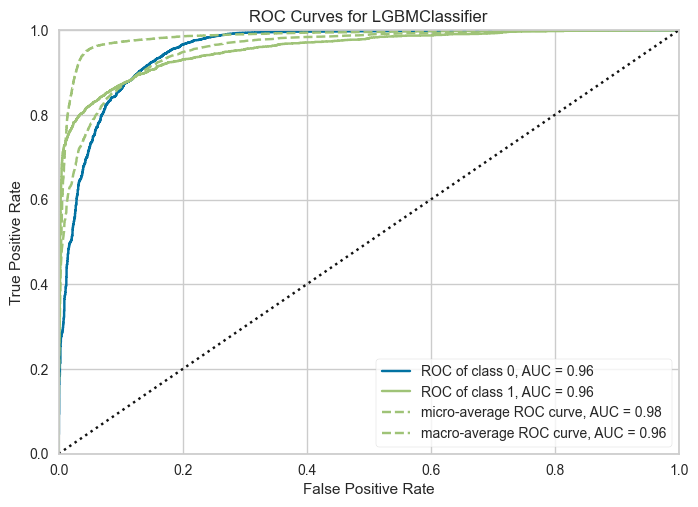

In [30]:
setup.plot_model(best_lightgbm, plot = 'auc')

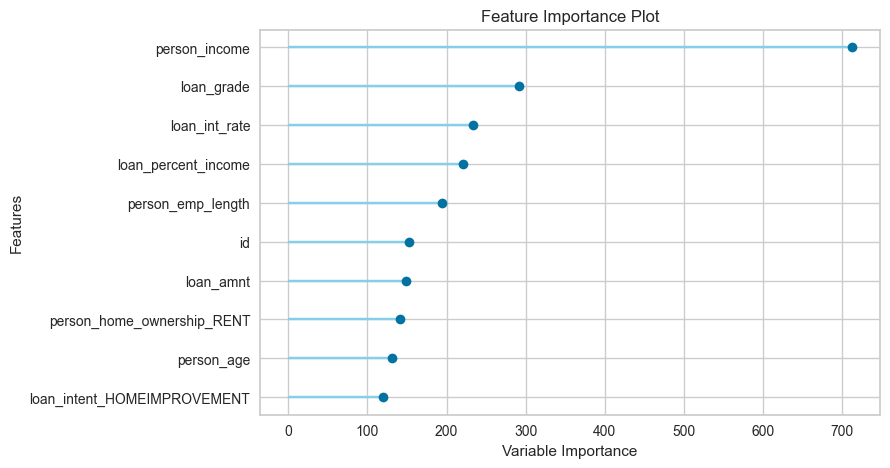

In [31]:
setup.plot_model(best_lightgbm, plot = 'feature')

## Model Predictions
Lets see what the model would predict on the actual test set.

In [32]:
df_test = ordinal_encoding(df_test)

predictions = setup.predict_model(best_lightgbm, data=df_test)
predictions.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,prediction_label,prediction_score
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,6,25000,15.760000,0.36,N,2,1,0.9954
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,3,10000,12.680000,0.10,Y,4,0,0.9713
2,58647,26,30000,RENT,5.0,VENTURE,5,4000,17.190001,0.13,Y,2,0,0.6234
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,1,7000,8.900000,0.14,N,7,0,0.9845
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,4,15000,16.320000,0.15,Y,4,0,0.9390
